In [1]:
import os

import pystablemotifs.random_boolean_networks as rbn

N_NODES_LIST = [10]
GRAPHS_PER_SIZE = 10
# For K=2, use p=0.5, for K=3, use p=0.211325
K = 3  # in-degree
p = 0.211325 # ratio of 1 in the truth table
DIRECTORY = "models/random_nk3"

for N_NODES in N_NODES_LIST:
    rules_list = rbn.random_boolean_network_ensemble_kauffman(N_NODES,K,p,GRAPHS_PER_SIZE,seed=1000)

    for i in range(GRAPHS_PER_SIZE):
        rules = rules_list[i]
        
        rules = rules.replace(" *=", ",")
        rules = rules.replace(" and ", " & ")
        rules = rules.replace(" or ", " | ")
        rules = rules.replace("not ", "!")

        writePath = DIRECTORY + f"/n{N_NODES:03}_{i:03}.bnet"
        isExist = os.path.exists(DIRECTORY)
        if not isExist:
            os.makedirs(DIRECTORY)

        with open(writePath, "w") as f:
            f.write("targets, factors\n")
            f.write(rules)

In [2]:
import numpy as np
from tqdm.autonotebook import tqdm

from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.state_transition_graphs import primes2stg
from pyboolnet.file_exchange import primes2bnet

from transition_matrix import get_transition_matrix
from matrix_operations import compress_matrix, expand_matrix
from matrix_operations import nsquare
from matrix_operations import get_rms_diff, get_dkl
from grouping import sd_grouping, null_grouping, random_grouping


def get_data(bnet, update="asynchronous", num_runs=100, DEBUG = False):

    data  = {"rmsd":{}, "dkl":{}}

    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}

    # Percolate constant nodes and remove them
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    percolated_bnet = primes2bnet(percolated_primes)

    # print(percolated_bnet)

    stg = primes2stg(percolated_primes, update)

    T = get_transition_matrix(stg, DEBUG=DEBUG)
    T_inf = nsquare(T, 20, DEBUG=DEBUG)

    sd_indexes = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tm = compress_matrix(T, sd_indexes, DEBUG=DEBUG)
    Tm_prime = expand_matrix(Tm, sd_indexes, DEBUG=DEBUG)
    Tm_inf = nsquare(Tm, 20, DEBUG=DEBUG)
    Tm_inf_prime = expand_matrix(Tm_inf, sd_indexes, DEBUG=DEBUG)

    data["rmsd"]["Tm"] = get_rms_diff(T, Tm_prime)
    data["dkl"]["Tm"] = get_dkl(T, Tm_prime)
    data["rmsd"]["Tm_inf"] = get_rms_diff(T_inf, Tm_inf_prime)
    data["dkl"]["Tm_inf"] = get_dkl(T_inf, Tm_inf_prime)

    null_indexes = null_grouping(percolated_bnet, DEBUG=DEBUG)
    T0 = compress_matrix(T, null_indexes, DEBUG=DEBUG)
    T0_prime = expand_matrix(T0, null_indexes, DEBUG=DEBUG)
    T0_inf = nsquare(T0, 20, DEBUG=DEBUG)
    T0_inf_prime = expand_matrix(T0_inf, null_indexes, DEBUG=DEBUG)

    data["rmsd"]["T0"] = get_rms_diff(T, T0_prime)
    data["dkl"]["T0"] = get_dkl(T, T0_prime)
    data["rmsd"]["T0_inf"] = get_rms_diff(T_inf, T0_inf_prime)
    data["dkl"]["T0_inf"] = get_dkl(T_inf, T0_inf_prime)

    rmsd = []
    dkl = []

    rmsd_inf = []
    dkl_inf = []

    for i in tqdm(range(num_runs), desc="Processing", unit="iteration", ncols=300, miniters=5):

        random_indexes = random_grouping(sd_indexes, null_indexes, seed=i, DEBUG=DEBUG)
        TRm = compress_matrix(T, random_indexes, DEBUG=DEBUG)
        TRm_prime = expand_matrix(TRm, random_indexes, DEBUG=DEBUG)
        TRm_inf = nsquare(TRm, 20, DEBUG=DEBUG)
        TRm_inf_prime = expand_matrix(TRm_inf, random_indexes, DEBUG=DEBUG)
        
        rmsd.append(get_rms_diff(T, TRm_prime))
        dkl.append(get_dkl(T, TRm_prime))

        rmsd_inf.append(get_rms_diff(T_inf, TRm_inf_prime))
        dkl_inf.append(get_dkl(T_inf, TRm_inf_prime))

    data["rmsd"]["TR"] = rmsd
    data["dkl"]["TR"] = dkl
    data["rmsd"]["TR_inf"] = rmsd_inf
    data["dkl"]["TR_inf"] = dkl_inf

    return data

/tmp/ipykernel_2872/1276012948.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# read files from DIRECTORY
import os

# Set the directory path
directory_path = "models/random_nk3"

all_data = {}

# Iterate over the files in the directory
for filename in sorted(os.listdir(directory_path)):

    if filename == "n010_006.bnet" or filename == "n010_007.bnet":
        continue

    file_path = os.path.join(directory_path, filename)
    
    # Check if it's a file (not a directory)
    if not os.path.isfile(file_path):
        continue

    # Open and read the file
    with open(file_path, 'r') as file:
        print(f"Reading file: {filename}")
        content = file.read()
    
    # print(content)
    
    data = get_data(bnet=content, DEBUG=True)

    all_data[filename] = data

    # print(f"{data["dkl"]["Tm"]=}")
    # print(f"{data["dkl"]["Tm_inf"]=}")
    # print(f"{data["dkl"]["T0"]=}")
    # print(f"{data["dkl"]["T0_inf"]=}")

    # break



Reading file: n010_000.bnet
No valid states found


Processing:   0%|                                                                                             …

Reading file: n010_001.bnet
No valid states found


domRec ignored: No domain atoms found.
domRec ignored: No domain atoms found.


Processing:   0%|                                                                                             …

Reading file: n010_002.bnet


Processing:   0%|                                                                                             …

Reading file: n010_003.bnet


Processing:   0%|                                                                                             …

Reading file: n010_004.bnet
No valid states found


Processing:   0%|                                                                                             …

Reading file: n010_005.bnet


Processing:   0%|                                                                                             …

Reading file: n010_006.bnet


ValueError: Duplicate states found: ['0000100000', '0100000000', '0100100000', '0000100000', '0100000000', '0100100000']

In [4]:
import matplotlib.pyplot as plt

def plot_histogram(data, xmax_rmsd=0.18, xmax_dkl=80, ymax=0.5):
    randoms = [np.array(data["rmsd"]["TR"]),
            np.array(data["dkl"]["TR"]),
            np.array(data["rmsd"]["TR_inf"]),
            np.array(data["dkl"]["TR_inf"])]

    sds = [data["rmsd"]["Tm"],
        data["dkl"]["Tm"],
        data["rmsd"]["Tm_inf"],
        data["dkl"]["Tm_inf"]]

    nulls = [data["rmsd"]["T0"],
            data["dkl"]["T0"],
            data["rmsd"]["T0_inf"],
            data["dkl"]["T0_inf"]]

    print(sds)
    print(nulls)

    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Loop over each dataset and corresponding reference value
    for i, (ran, sd, null) in enumerate(zip(randoms, sds, nulls)):
        row, col = divmod(i, 2)  # Determine subplot position
        ax = axs[row, col]

        # Calculate the mean and standard deviation
        mean = np.mean(ran)
        std_dev = np.std(ran)

        # Calculate the Z-score of the reference number
        z_score = (sd - mean) / std_dev


        binwidth = xmax_rmsd/100
        if i == 1 or i == 3:
            binwidth = xmax_dkl/100

        # Create the histogram
        hist, bins = np.histogram(ran, bins=np.arange(min(ran), max(ran) + binwidth, binwidth))    

        # Calculate the ratio
        ratio = hist / hist.sum()

        if i == 2 or i == 3:
            inf = "∞"
        else:
            inf = ""

        # Plot histogram and reference line
        ax.bar(bins[:-1], ratio, width=np.diff(bins), align='edge', alpha=0.7)
        ax.axvline(sd, color='red', linestyle='-', linewidth=1, label=f'Tm{inf} (Z-score = {z_score:.2f})')
        ax.axvline(null, color='black', linestyle='-', linewidth=1, label='Null')
        # Adding lines for mean
        ax.axvline(mean, color='blue', linestyle='--', linewidth=1, label='Mean')

        # Set the labels, limits, and legend for each subplot
        ax.set_xlabel('Value')
        ax.set_ylabel('Ratio')
        ax.set_ylim(0, ymax)
        ax.legend()

    axs[0,0].set_title("RMSD")
    axs[0,1].set_title("Dkl")
    axs[1,0].set_title("RMSD_inf")
    axs[1,1].set_title("Dkl_inf")

    axs[0,0].set_xlim(-xmax_rmsd/100, xmax_rmsd)
    axs[0,1].set_xlim(-xmax_dkl/100, xmax_dkl)
    axs[1,0].set_xlim(-xmax_rmsd/100, xmax_rmsd)
    axs[1,1].set_xlim(-xmax_dkl/100, xmax_dkl)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

[np.float64(0.07254368894366729), np.float64(186.57333801917713), np.float64(0.03045931943546891), np.float64(76.8587605004052)]
[np.float64(0.07254368894366729), np.float64(186.57333801917713), np.float64(0.03045931943546891), np.float64(76.8587605004052)]


/tmp/ipykernel_24562/453583564.py:35: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (sd - mean) / std_dev


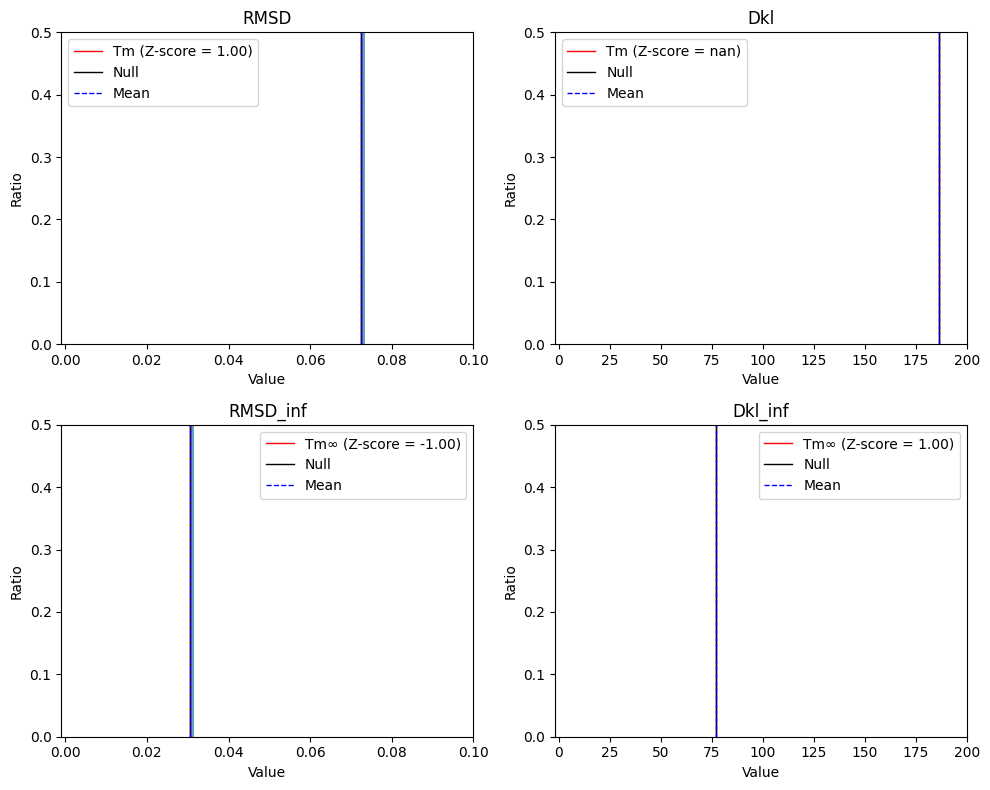

In [ ]:
plot_histogram(all_data["n010_005.bnet"], xmax_rmsd=0.1, xmax_dkl=200)